In [0]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install tensorflow
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession

MAX_MEMORY = "10g"

spark = SparkSession \
    .builder \
    .appName("Foo") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

# spark = SparkSession.builder.master("local[*]").getOrCreate()
spark_home = os.environ.get('SPARK_HOME', None)

#Get Data
!wget "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Packages [25.5 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 

**Importing Required Libraries**

In [0]:
from pyspark import SparkContext
sc = spark.sparkContext

import os
import numpy as np
import pandas as pd
import _pickle as cPickle
import sys
import operator
import json

from pyspark import SparkConf, SparkContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest, DecisionTreeModel
from pyspark.mllib.classification import SVMWithSGD
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import os
import sys
import tarfile
import pickle
import cv2
import matplotlib.pyplot as plt
import random
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import NaiveBayes
import pyspark.sql.functions as F
import time
%matplotlib inline

**Extracting the Dataset**

In [0]:
#Extracting Dataset
data_root = '.'

def _extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()

dataset = os.path.join(data_root, 'cifar-100-python.tar.gz')

_extract(dataset)

Extracting data for ./cifar-100-python.


**Loading the extracted dataset and printing the both the labels (course labels and fine labels)**

In [0]:
#  load a pickle file
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


# load train, test, and meta
train_dec = unpickle('./cifar-100-python/train')
test_dec = unpickle('./cifar-100-python/test')
meta = unpickle('./cifar-100-python/meta')


#printing values of meta file 
fine_labels = [x.decode('utf-8') for x in meta.get(b'fine_label_names')]
print('Fine Labels :', fine_labels)
coarse_labels = [x.decode('utf-8') for x in meta.get(b'coarse_label_names')]
print('Coarse Labels :', coarse_labels)

Fine Labels : ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 

**Combining the train data and test data.**

In [0]:
datatrain=sc.parallelize(zip(train_dec[b'data'].tolist(),train_dec[b'coarse_labels'],train_dec[b'fine_labels']))
datatest=sc.parallelize(zip(test_dec[b'data'].tolist(),test_dec[b'coarse_labels'],test_dec[b'fine_labels']))
data = spark.createDataFrame(datatrain.union(datatest)) 
# data.count()
# data.show(2)

**Renaming the columns**

In [0]:
#Renaming the columns
data=data.withColumnRenamed("_1","features").withColumnRenamed("_2","coarse_labels").withColumnRenamed("_3","fine_labels")

**Finding the index of super class Vehicle 1 and Vehicle 2**

In [0]:
#finding index of assigned superclass vehicles_1 and vehicles_2
vehicles1_index = [coarse_labels.index(x) for x in coarse_labels if x == 'vehicles_1']
vehicles2_index = [coarse_labels.index(x) for x in coarse_labels if x == 'vehicles_2']

#printing index
print(vehicles1_index)
print(vehicles2_index)

[18]
[19]


**Filtering the dataset to get Vehicle 1 and Vehicle 2 data**

In [0]:
data=data.filter((data['coarse_labels']==18) | (data['coarse_labels']==19))
# data.show(2)

**Filtering the dataset to get Subclasses in each SuperClass (Vehicle 1 and Vehicle 2)**

In [0]:
#Making a list of subclasses from vehicle 1
sub_vehicle_1=[int(row.fine_labels) for row in data.filter(data['coarse_labels']==18).select('fine_labels').distinct().collect()]
print(sub_vehicle_1)

[58, 48, 8, 13, 90]


In [0]:
#Making a list of subclasses from vehicle 2
sub_vehicle_2=[int(row.fine_labels) for row in data.filter(data['coarse_labels']==19).select('fine_labels').distinct().collect()]
print(sub_vehicle_2)

[41, 89, 85, 69, 81]


**Validating the data by plotting with coarse labels and fine labels**

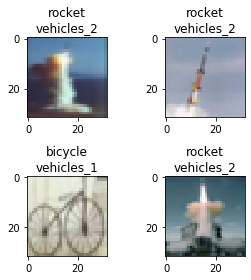

In [0]:
#Taking random data 
sample = data.rdd.takeSample(withReplacement=False,num=4)

# To view sample data
fig = plt.figure(figsize=(4, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
k=1
for i in sample:
    ax = fig.add_subplot(2, 2, k)
    img = np.array(i['features']).reshape(3,32,32).transpose([1, 2, 0])
    fig.set_tight_layout(True) 
    ax=plt.imshow(img)
    a = fine_labels[i['fine_labels']]
    b = coarse_labels[i['coarse_labels']]
    ax=plt.title(a+"\n"+b)
    k=k+1


# ****Preprocessing the data for training models****

**Creating dense vectors and creating 1 and 0 labels**

In [0]:
data = data.rdd.map(lambda x: Row(features=Vectors.dense(x.features), coarse_labels=x.coarse_labels, fine_labels=x.fine_labels)).toDF()
#Divide x[0] by 255 to normalize the data

#Converting labels 18 and 19 to 1 and 0 respectively
stringindexer = StringIndexer(inputCol='coarse_labels', outputCol='labelindex')
data = stringindexer.fit(data).transform(data)
# data.show(2)

**Creating the Model**

# 1. Random Forest

   

1.   We run 25 trials in loop, taking one different subclass pair out as a test set in each iteration.
2.   We save the model which gets the highest accuracy(maxscore) in those 25   trails loop.
3.   Accuracy is calculated from the confusion matrix.
4.   For each iteration we print the subclass pair, accuracy, train time, test time, AUC 







In [0]:
maxscore=-1
for i in sub_vehicle_1:
  for j in sub_vehicle_2:
    print("Sub Type 1:",str(i) +" "+ fine_labels[i],",","Sub Type 2:",str(j)+" "+ fine_labels[j])
    train = data.filter( (data['fine_labels']!= i) & (data['fine_labels']!= j) )
    test = data.filter((data['fine_labels']== i) | (data['fine_labels']== j))
    # train = data.filter( (data['fine_labels']!= 58) & (data['fine_labels']!= 41) )
    # test = data.filter((data['fine_labels']== 58) | (data['fine_labels']== 41))
    
    
    #Creating an object
    rfc=RandomForestClassifier(featuresCol="features", labelCol="labelindex",numTrees=155,seed=55)
    #Fitting Random Forest Classifier to the training data
    start = time.clock()
    print("Start CPU Time for fitting the model")
    rfc_model=rfc.fit(train)
    end = time.clock()
    print("CPU Time taken for training:",end - start)
    #Predicting with test data
    start1 = time.clock()
    print("Start CPU Time for testing the model")
    rfc_prediction=rfc_model.transform(test)
    end1 = time.clock()
    print("CPU Time taken for testing:",end1 - start1)
    rfc_eval=BinaryClassificationEvaluator(labelCol="labelindex")
    print("Area Under The Curve: %.3f" % rfc_eval.evaluate(rfc_prediction))
    predictionRDD = rfc_prediction.select(['labelindex', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)
    # Confusion Matrix
    cm = metrics.confusionMatrix().toArray()
    # Accuracy
    accuracy=(cm[0][0] + cm[1][1])/(cm[0][0] + cm[1][1]+ cm[0][1]+ cm[1][0])
    print("Accuracy :  %.3f" % accuracy)
    print("-------------------------------")
    #Saving model only if it is accurate as compared to the previous one
    if(maxscore<accuracy):
      print("saving model")
      print("-------------------------------")
      maxscore=accuracy
      rfc_model.write().overwrite().save("/content/Random_Forest") 

Sub Type 1: 58 pickup_truck , Sub Type 2: 41 lawn_mower
pickup_truck lawn_mower
Start CPU Time for fitting the model
CPU Time taken for training: 0.035192000000000334
Start CPU Time for testing the model
CPU Time taken for testing: 0.00877399999999895
Area Under The Curve: 0.522
Accuracy :  0.532
-------------------------------
saving model
-------------------------------
Sub Type 1: 58 pickup_truck , Sub Type 2: 89 tractor
pickup_truck tractor
Start CPU Time for fitting the model
CPU Time taken for training: 0.03654599999999952
Start CPU Time for testing the model
CPU Time taken for testing: 0.009548000000000556
Area Under The Curve: 0.457
Accuracy :  0.459
-------------------------------
Sub Type 1: 58 pickup_truck , Sub Type 2: 85 tank
pickup_truck tank
Start CPU Time for fitting the model
CPU Time taken for training: 0.03175400000000117
Start CPU Time for testing the model
CPU Time taken for testing: 0.010074999999998724
Area Under The Curve: 0.476
Accuracy :  0.497
---------------

In [0]:
#Saving the Model for future use
!zip -r /content/Random_Forest.zip /content/Random_Forest/

updating: content/new/ (stored 0%)
  adding: content/new/data/ (stored 0%)
  adding: content/new/data/.part-00000-f185b927-b06c-4e3c-a94e-d6b672343631-c000.snappy.parquet.crc (stored 0%)
  adding: content/new/data/.part-00001-f185b927-b06c-4e3c-a94e-d6b672343631-c000.snappy.parquet.crc (stored 0%)
  adding: content/new/data/._SUCCESS.crc (stored 0%)
  adding: content/new/data/_SUCCESS (stored 0%)
  adding: content/new/data/part-00001-f185b927-b06c-4e3c-a94e-d6b672343631-c000.snappy.parquet (deflated 14%)
  adding: content/new/data/part-00000-f185b927-b06c-4e3c-a94e-d6b672343631-c000.snappy.parquet (deflated 15%)
  adding: content/new/metadata/ (stored 0%)
  adding: content/new/metadata/.part-00000.crc (stored 0%)
  adding: content/new/metadata/._SUCCESS.crc (stored 0%)
  adding: content/new/metadata/_SUCCESS (stored 0%)
  adding: content/new/metadata/part-00000 (deflated 45%)
  adding: content/new/treesMetadata/ (stored 0%)
  adding: content/new/treesMetadata/.part-00000-0bfc2035-a3b3-

In [0]:
from google.colab import files
files.download("/content/Random_Forest.zip")

In [0]:
#Loading the Best Model with highest Accuracy
!unzip /content/Random_Forest.zip
ab=RandomForestClassificationModel.load('/content/content/new')
#specifying the test data subtypes with highest accuracy
test = data.filter((data['fine_labels']== 48) | (data['fine_labels']== 41))
rfc_prediction=ab.transform(test)
rfc_eval=BinaryClassificationEvaluator(labelCol="labelindex")
print("Area Under The Curve: %.3f" % rfc_eval.evaluate(rfc_prediction))

Archive:  /content/file.zip
   creating: content/new/
   creating: content/new/data/
 extracting: content/new/data/.part-00000-f185b927-b06c-4e3c-a94e-d6b672343631-c000.snappy.parquet.crc  
 extracting: content/new/data/.part-00001-f185b927-b06c-4e3c-a94e-d6b672343631-c000.snappy.parquet.crc  
 extracting: content/new/data/._SUCCESS.crc  
 extracting: content/new/data/_SUCCESS  
  inflating: content/new/data/part-00001-f185b927-b06c-4e3c-a94e-d6b672343631-c000.snappy.parquet  
  inflating: content/new/data/part-00000-f185b927-b06c-4e3c-a94e-d6b672343631-c000.snappy.parquet  
   creating: content/new/metadata/
 extracting: content/new/metadata/.part-00000.crc  
 extracting: content/new/metadata/._SUCCESS.crc  
 extracting: content/new/metadata/_SUCCESS  
  inflating: content/new/metadata/part-00000  
   creating: content/new/treesMetadata/
 extracting: content/new/treesMetadata/.part-00000-0bfc2035-a3b3-4486-a6f4-20811278fc27-c000.snappy.parquet.crc  
  inflating: content/new/treesMetad

**Plotting Predicted Images**

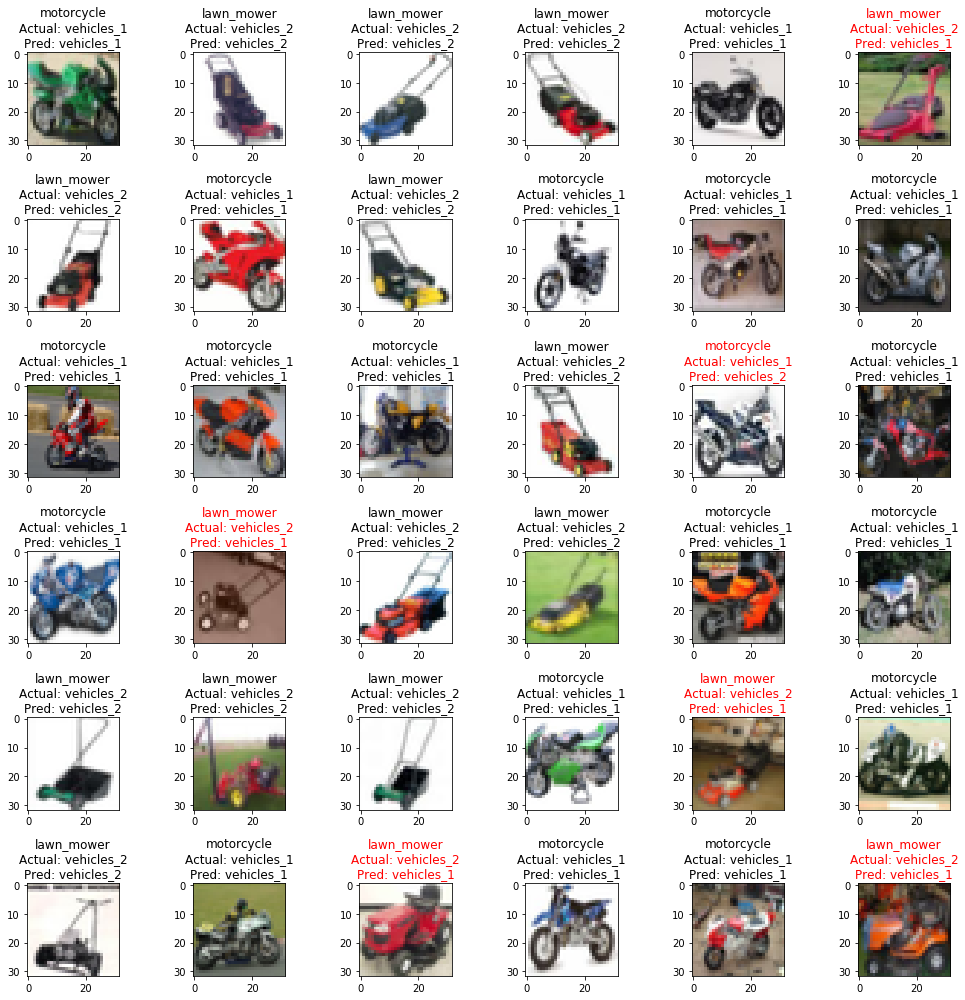

In [0]:
#Taking random data from test data to print predicted images
sample = rfc_prediction.rdd.takeSample(withReplacement=False,num=36)

# To view sample data
fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(hspace=0.8, wspace=0.8)
k=1
for i in sample:
    ax = fig.add_subplot(6, 6, k)
    img = np.array(i['features'].astype(int)).reshape(3,32,32).transpose([1, 2, 0])
    fig.set_tight_layout(True) 
    ax=plt.imshow(img)
    a = fine_labels[i['fine_labels']]
    b = coarse_labels[i['coarse_labels']]
    if i['prediction']==1:
      m=18
    elif i['prediction']==0:
      m=19
    c = coarse_labels[m]
    if i['prediction']== i['labelindex']:
      ax=plt.title(a+"\nActual: "+b +"\nPred: "+c)
    else:
      ax=plt.title(a+"\nActual: "+b +"\nPred: "+c, color = 'red')
    k=k+1

**Confusion Matrix and Classification Report**

In [0]:
rfc_eval=BinaryClassificationEvaluator(labelCol="labelindex")
print("Area Under The Curve: %.3f" % rfc_eval.evaluate(rfc_prediction))


Area Under The Curve: 0.753


In [0]:
conf_mat = rfc_prediction.select('labelindex', 'prediction')
conf_mat.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(labelindex=0.0, prediction=0.0): 342,
             Row(labelindex=0.0, prediction=1.0): 258,
             Row(labelindex=1.0, prediction=0.0): 101,
             Row(labelindex=1.0, prediction=1.0): 499})

In [0]:
predictionRDD = rfc_prediction.select(['labelindex', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)

In [0]:
# Confusion Matrix for the model with highest accuracy
cm = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print("%10s %12s %12s" % ("real\pred" ,"predicted 0", "predicted 1"))
for i in range (0,2):
  print("real %2s" % i, end='')
  for j in range (0,2):
    print("%12d" % cm[i][j], end='')
  print()

Confusion Matrix:
 real\pred  predicted 0  predicted 1
real  0         342         258
real  1         101         499


In [0]:
# Define a function to evaluate each of the two labels, i.e., 0 and 1 for the best performing classifiaction sub classes
def cr(label_in):
  precision = metrics.precision(label=label_in)
  recall = metrics.recall(label=label_in)
  F1_Measure = metrics.fMeasure(label=label_in)
  support = test.filter(test.labelindex==label_in).count()
  print("%10s %12.2f  %12.2f %12.2f %12d" % \
          (label_in,precision, recall, F1_Measure, support))

In [0]:
print("            Classification Report")
print("%10s %12s  %12s %12s %12s"    % ("label","precision","recall","f1-score","support"))
for i in np.arange(0.0, 2.0, 1.0):
  cr(i)

            Classification Report
     label    precision        recall     f1-score      support
       0.0         0.77          0.57         0.66          600
       1.0         0.66          0.83         0.74          600


In [0]:
# Accuracy
print("Accuracy :  %.3f" %((cm[0][0] + cm[1][1])/(cm[0][0] + cm[1][1]+ cm[0][1]+ cm[1][0])))

Accuracy :  0.701


# 2. Naive Bayes

   

1.   We run 25 trials in loop, taking one different subclass pair out as a test set in each iteration.
2.   We save the model which gets the highest accuracy(maxscore) in those 25   trails loop.
3.   Accuracy is calculated from the confusion matrix.
4.   For each iteration we print the subclass pair, accuracy, train time, test time, AUC 







In [0]:
maxscore=-1
for i in sub_vehicle_1:
  for j in sub_vehicle_2:
    print("Sub Type 1:",str(i) +" "+ fine_labels[i],",","Sub Type 2:",str(j)+" "+ fine_labels[j])
    train = data.filter( (data['fine_labels']!= i) & (data['fine_labels']!= j) )
    test = data.filter((data['fine_labels']== i) | (data['fine_labels']== j))
    
    
    #Creating an object
    nb = NaiveBayes(featuresCol="features", labelCol="labelindex",smoothing=1.0, modelType="multinomial")
    
    #Fitting Naive Bayes Classifier to the training data
    start = time.clock()
    print("Start CPU Time for fitting the model")
    nb_model = nb.fit(train)

    end = time.clock()
    print("CPU Time taken for fitting the model:",end - start)
    #Predicting with test data
    start1 = time.clock()
    print("Start CPU Time for testing the model")
    pred = nb_model.transform(test)
    end1 = time.clock()
    print("CPU Time taken for testing the model:",end1 - start1)

    nb_eval=BinaryClassificationEvaluator(labelCol="labelindex")
    print("Area Under The Curve: %.3f" % nb_eval.evaluate(pred))
    predictionRDD = pred.select(['labelindex', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)
    # Confusion Matrix
    cm = metrics.confusionMatrix().toArray()
    # Accuracy
    accuracy=(cm[0][0] + cm[1][1])/(cm[0][0] + cm[1][1]+ cm[0][1]+ cm[1][0])
    print("Accuracy :  %.3f" % accuracy)
    print("-------------------------------")
    #Saving model only if it is accurate as compared to the previous one
    if(maxscore<accuracy):
      print("saving model")
      print("-------------------------------")
      maxscore=accuracy
      nb_model.write().overwrite().save("/content/Naive_Bayes/") 

Sub Type 1: 58 pickup_truck , Sub Type 2: 41 lawn_mower
pickup_truck lawn_mower
Start CPU Time for fitting the model
CPU Time taken for fitting the model: 0.019317000000000917
Start CPU Time for testing the model
CPU Time taken for testing the model: 0.0075120000000019616
Area Under The Curve: 0.718
Accuracy :  0.517
-------------------------------
saving model
-------------------------------
Sub Type 1: 58 pickup_truck , Sub Type 2: 89 tractor
pickup_truck tractor
Start CPU Time for fitting the model
CPU Time taken for fitting the model: 0.021408000000000982
Start CPU Time for testing the model
CPU Time taken for testing the model: 0.004860999999998228
Area Under The Curve: 0.528
Accuracy :  0.468
-------------------------------
Sub Type 1: 58 pickup_truck , Sub Type 2: 85 tank
pickup_truck tank
Start CPU Time for fitting the model


Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'NaiveBayes' object has no attribute '_java_obj'


CPU Time taken for fitting the model: 0.029701000000002864
Start CPU Time for testing the model
CPU Time taken for testing the model: 0.006845000000001988
Area Under The Curve: 0.627
Accuracy :  0.461
-------------------------------
Sub Type 1: 58 pickup_truck , Sub Type 2: 69 rocket
pickup_truck rocket
Start CPU Time for fitting the model
CPU Time taken for fitting the model: 0.026997000000001492
Start CPU Time for testing the model
CPU Time taken for testing the model: 0.0065390000000000725
Area Under The Curve: 0.671
Accuracy :  0.328
-------------------------------
Sub Type 1: 58 pickup_truck , Sub Type 2: 81 streetcar
pickup_truck streetcar
Start CPU Time for fitting the model
CPU Time taken for fitting the model: 0.01780700000000124
Start CPU Time for testing the model
CPU Time taken for testing the model: 0.005081000000000557
Area Under The Curve: 0.498
Accuracy :  0.472
-------------------------------
Sub Type 1: 48 motorcycle , Sub Type 2: 41 lawn_mower
motorcycle lawn_mower
S

In [0]:
#Saving the Model for future use
!zip -r /content/Naive_Bayes.zip /content/Naive_Bayes/

  adding: content/Naive_Bayes/ (stored 0%)
  adding: content/Naive_Bayes/data/ (stored 0%)
  adding: content/Naive_Bayes/data/part-00000-83b87993-7aae-4c13-80df-dab4ec00639b-c000.snappy.parquet (deflated 17%)
  adding: content/Naive_Bayes/data/.part-00000-83b87993-7aae-4c13-80df-dab4ec00639b-c000.snappy.parquet.crc (stored 0%)
  adding: content/Naive_Bayes/data/._SUCCESS.crc (stored 0%)
  adding: content/Naive_Bayes/data/_SUCCESS (stored 0%)
  adding: content/Naive_Bayes/metadata/ (stored 0%)
  adding: content/Naive_Bayes/metadata/.part-00000.crc (stored 0%)
  adding: content/Naive_Bayes/metadata/._SUCCESS.crc (stored 0%)
  adding: content/Naive_Bayes/metadata/_SUCCESS (stored 0%)
  adding: content/Naive_Bayes/metadata/part-00000 (deflated 48%)


In [0]:
from google.colab import files
files.download("/content/Naive_Bayes.zip")

In [0]:
#Loading the Best Model with highest Accuracy
!unzip /content/Naive_Bayes.zip
ab=nb_model.load('/content/content/Naive_Bayes')
#specifying the test data subtypes with highest accuracy
test = data.filter((data['fine_labels']== 48) | (data['fine_labels']== 41))
pred=ab.transform(test)
nb_eval=BinaryClassificationEvaluator(labelCol="labelindex")
print("Area Under The Curve: %.3f" % nb_eval.evaluate(pred))

Area Under The Curve: 0.676


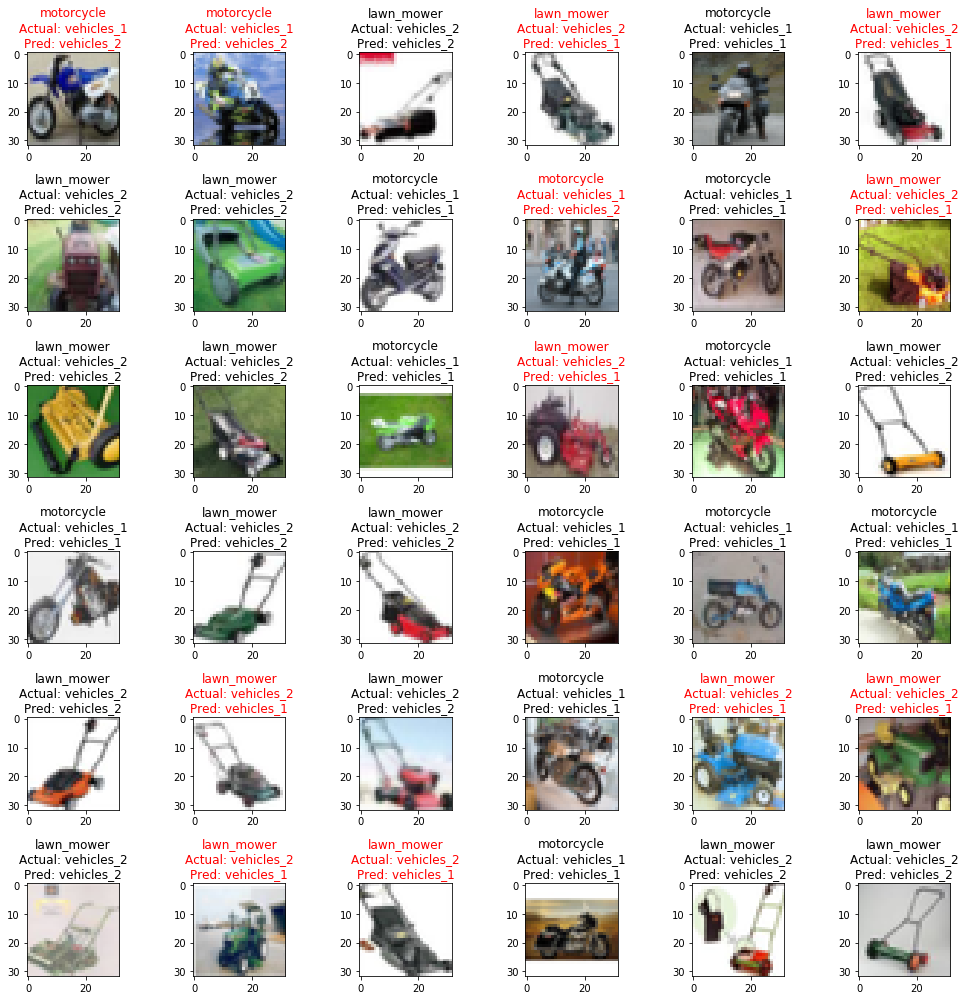

In [0]:
#Taking random data from test data to print predicted images
sample = pred.rdd.takeSample(withReplacement=False,num=36)

# To view sample data
fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(hspace=0.8, wspace=0.8)
k=1
for i in sample:
    ax = fig.add_subplot(6, 6, k)
    img = np.array(i['features'].astype(int)).reshape(3,32,32).transpose([1, 2, 0])
    fig.set_tight_layout(True) 
    ax=plt.imshow(img)
    a = fine_labels[i['fine_labels']]
    b = coarse_labels[i['coarse_labels']]
    if i['prediction']==1:
      m=18
    elif i['prediction']==0:
      m=19
    c = coarse_labels[m]
    if i['prediction']== i['labelindex']:
      ax=plt.title(a+"\nActual: "+b +"\nPred: "+c)
    else:
      ax=plt.title(a+"\nActual: "+b +"\nPred: "+c, color = 'red')
    k=k+1

In [0]:
conf_mat = pred.select('labelindex', 'prediction')
conf_mat.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(labelindex=0.0, prediction=0.0): 245,
             Row(labelindex=0.0, prediction=1.0): 355,
             Row(labelindex=1.0, prediction=0.0): 139,
             Row(labelindex=1.0, prediction=1.0): 461})

In [0]:
predictionRDD = pred.select(['labelindex', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)

In [0]:
# Confusion Matrix for the model with highest accuracy
cm = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print("%10s %12s %12s" % ("real\pred" ,"predicted 0", "predicted 1"))
for i in range (0,2):
  print("real %2s" % i, end='')
  for j in range (0,2):
    print("%12d" % cm[i][j], end='')
  print()

Confusion Matrix:
 real\pred  predicted 0  predicted 1
real  0         245         355
real  1         139         461


In [0]:
# Define a function to evaluate each of the two labels, i.e., 0 and 1 for the best performing classifiaction sub classes
def cr(label_in):
  precision = metrics.precision(label=label_in)
  recall = metrics.recall(label=label_in)
  F1_Measure = metrics.fMeasure(label=label_in)
  support = test.filter(test.labelindex==label_in).count()
  print("%10s %12.2f  %12.2f %12.2f %12d" % \
          (label_in,precision, recall, F1_Measure, support))

In [0]:
print("            Classification Report")
print("%10s %12s  %12s %12s %12s"    % ("label","precision","recall","f1-score","support"))
for i in np.arange(0.0, 2.0, 1.0):
  cr(i)

            Classification Report
     label    precision        recall     f1-score      support
       0.0         0.64          0.41         0.50          600
       1.0         0.56          0.77         0.65          600


In [0]:
# Accuracy
print("Accuracy :  %.3f" %((cm[0][0] + cm[1][1])/(cm[0][0] + cm[1][1]+ cm[0][1]+ cm[1][0])))

Accuracy :  0.588
